In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

in_df = pd.read_csv(r"C:\Users\Danil\YandexDisk\Python\Practic\WeatherForecasting\Filtering_data\filtered_df.csv")
df = pd.concat([in_df[in_df.columns[6]].shift(i) for i in range(365,0,-1)], axis=1)
df = df[365:]
df.columns = range(365)

df

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
365,-4.70,-7.60,-11.60,-4.90,-0.60,-1.50,-4.10,-1.40,0.30,0.10,...,-5.40,-6.70,-3.90,-4.20,-3.80,-3.90,-4.30,-6.00,1.60,0.30
366,-7.60,-11.60,-4.90,-0.60,-1.50,-4.10,-1.40,0.30,0.10,-0.10,...,-6.70,-3.90,-4.20,-3.80,-3.90,-4.30,-6.00,1.60,0.30,-4.65
367,-11.60,-4.90,-0.60,-1.50,-4.10,-1.40,0.30,0.10,-0.10,-1.60,...,-3.90,-4.20,-3.80,-3.90,-4.30,-6.00,1.60,0.30,-4.65,-7.55
368,-4.90,-0.60,-1.50,-4.10,-1.40,0.30,0.10,-0.10,-1.60,-7.00,...,-4.20,-3.80,-3.90,-4.30,-6.00,1.60,0.30,-4.65,-7.55,-11.55
369,-0.60,-1.50,-4.10,-1.40,0.30,0.10,-0.10,-1.60,-7.00,-9.40,...,-3.80,-3.90,-4.30,-6.00,1.60,0.30,-4.65,-7.55,-11.55,-4.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7295,-5.17,-5.57,-7.28,0.30,-0.99,-6.00,-8.90,-12.91,-6.22,-1.92,...,-1.43,-3.14,-3.85,-8.45,-10.26,-8.86,-10.17,-7.38,-7.68,-7.29
7296,-5.57,-7.28,0.30,-0.99,-6.00,-8.90,-12.91,-6.22,-1.92,-2.83,...,-3.14,-3.85,-8.45,-10.26,-8.86,-10.17,-7.38,-7.68,-7.29,-7.39
7297,-7.28,0.30,-0.99,-6.00,-8.90,-12.91,-6.22,-1.92,-2.83,-5.43,...,-3.85,-8.45,-10.26,-8.86,-10.17,-7.38,-7.68,-7.29,-7.39,-7.80
7298,0.30,-0.99,-6.00,-8.90,-12.91,-6.22,-1.92,-2.83,-5.43,-2.74,...,-8.45,-10.26,-8.86,-10.17,-7.38,-7.68,-7.29,-7.39,-7.80,-9.51


In [2]:
df_y = pd.DataFrame(index = range(365, 7299), columns=[0])
for i in range(365, 7299):
  df_y[0][i] = df[0][i+1]
df = df.reset_index(drop=True)
df_y = df_y.reset_index(drop=True)
df_y

,0
0,-7.6
1,-11.6
2,-4.9
3,-0.6
4,-1.5
...,...
6929,-5.17
6930,-5.57
6931,-7.28
6932,0.3


In [3]:
train_len = 365*17
train_x = df[:train_len].values
train_y = df_y[:train_len].values

valid_x = df[train_len : train_len + 365].values
valid_y = df_y[train_len : train_len + 365].values

test_x = df[train_len + 365 : train_len + 365*2]
test_x = test_x.drop(df.index[-1]).values
test_y = df_y[train_len + 365 : train_len + 365*2].values

In [4]:
df[train_len : train_len + 365]

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
6205,-1.55,-4.45,-8.46,-1.76,2.52,1.61,-0.98,1.70,3.40,3.19,...,-4.41,-5.72,-2.92,-3.23,-2.83,-2.94,-3.35,-5.05,2.53,1.22
6206,-4.45,-8.46,-1.76,2.52,1.61,-0.98,1.70,3.40,3.19,2.98,...,-5.72,-2.92,-3.23,-2.83,-2.94,-3.35,-5.05,2.53,1.22,-3.77
6207,-8.46,-1.76,2.52,1.61,-0.98,1.70,3.40,3.19,2.98,1.48,...,-2.92,-3.23,-2.83,-2.94,-3.35,-5.05,2.53,1.22,-3.77,-6.68
6208,-1.76,2.52,1.61,-0.98,1.70,3.40,3.19,2.98,1.48,-3.92,...,-3.23,-2.83,-2.94,-3.35,-5.05,2.53,1.22,-3.77,-6.68,-10.68
6209,2.52,1.61,-0.98,1.70,3.40,3.19,2.98,1.48,-3.92,-6.32,...,-2.83,-2.94,-3.35,-5.05,2.53,1.22,-3.77,-6.68,-10.68,-3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,-2.94,-3.35,-5.05,2.53,1.22,-3.77,-6.68,-10.68,-3.99,0.29,...,0.78,-0.91,-1.62,-6.22,-8.03,-6.64,-7.94,-5.15,-5.46,-5.06
6566,-3.35,-5.05,2.53,1.22,-3.77,-6.68,-10.68,-3.99,0.29,-0.60,...,-0.91,-1.62,-6.22,-8.03,-6.64,-7.94,-5.15,-5.46,-5.06,-5.17
6567,-5.05,2.53,1.22,-3.77,-6.68,-10.68,-3.99,0.29,-0.60,-3.21,...,-1.62,-6.22,-8.03,-6.64,-7.94,-5.15,-5.46,-5.06,-5.17,-5.57
6568,2.53,1.22,-3.77,-6.68,-10.68,-3.99,0.29,-0.60,-3.21,-0.51,...,-6.22,-8.03,-6.64,-7.94,-5.15,-5.46,-5.06,-5.17,-5.57,-7.28


In [15]:
test_x

array([[ -3.77,  -6.68, -10.68, ...,  -7.28,   0.3 ,  -0.99],
       [ -6.68, -10.68,  -3.99, ...,   0.3 ,  -0.99,  -6.  ],
       [-10.68,  -3.99,   0.29, ...,  -0.99,  -6.  ,  -8.9 ],
       ...,
       [ -5.57,  -7.28,   0.3 , ...,  -7.68,  -7.29,  -7.39],
       [ -7.28,   0.3 ,  -0.99, ...,  -7.29,  -7.39,  -7.8 ],
       [  0.3 ,  -0.99,  -6.  , ...,  -7.39,  -7.8 ,  -9.51]])

In [16]:
test_y

array([[-6.68],
       [-10.68],
       [-3.99],
       [0.29],
       [-0.6],
       [-3.21],
       [-0.51],
       [1.17],
       [0.96],
       [0.76],
       [-0.74],
       [-6.14],
       [-8.55],
       [-11.26],
       [-8.56],
       [-5.57],
       [-4.98],
       [-4.98],
       [-10.99],
       [-10.59],
       [-16.5],
       [-16.01],
       [-19.11],
       [-20.42],
       [-23.42],
       [-9.63],
       [-0.04],
       [0.95],
       [-0.55],
       [-0.65],
       [-4.96],
       [0.12],
       [1.32],
       [-4.68],
       [-0.79],
       [-3.39],
       [0.99],
       [1.79],
       [2.28],
       [1.97],
       [0.97],
       [1.56],
       [1.36],
       [-0.44],
       [-0.75],
       [-0.95],
       [-1.36],
       [-0.06],
       [2.52],
       [1.21],
       [-2.08],
       [-5.69],
       [-8.29],
       [-10.5],
       [-9.01],
       [-5.51],
       [-10.12],
       [-5.23],
       [0.76],
       [2.15],
       [1.35],
       [1.44],
       [1.23],
     

In [6]:
import xgboost as xgb
print("XGB Version:", xgb.__version__)

XGB Version: 1.7.6


In [7]:
params = {
    "objective": "reg:squarederror",
    "n_estimators":200,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "colsample_bylevel": 0.8,
    "reg_lambda": 0.1,
    "eval_metric": "mae",
    "random_state": 314,
}

reg = xgb.XGBRegressor(**params)

In [8]:
reg.fit(train_x,
        train_y,
        verbose=False,
        eval_set= [(train_x, train_y), (valid_x, valid_y)],
        early_stopping_rounds= 3
        )

d:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=314, ...)

Text(0, 0.5, 'RMSE Deviance')

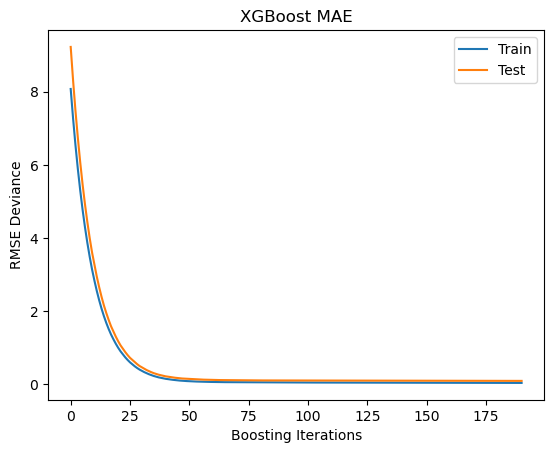

In [9]:
results = reg.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')

plt.legend()
plt.title('XGBoost MAE')
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Deviance")

In [10]:
results['validation_0']['mae'][-1]

0.03883163871800439

In [11]:
y_pred = reg.predict(test_x)

In [12]:
import matplotlib.pylab as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 10
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.style.use('seaborn-whitegrid')
mpl.rc('font', size=13)
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['axes.linewidth'] = 2

C:\Users\Danil\AppData\Local\Temp\ipykernel_11200\1930917007.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


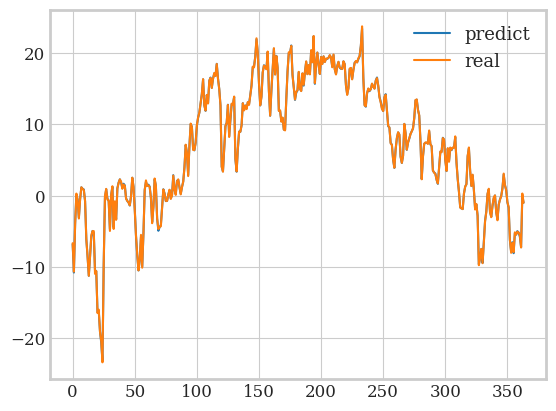

In [13]:
plt.plot(range(364), y_pred, label="predict")
plt.plot(range(364), test_y, label="real")
plt.legend()
plt.show()

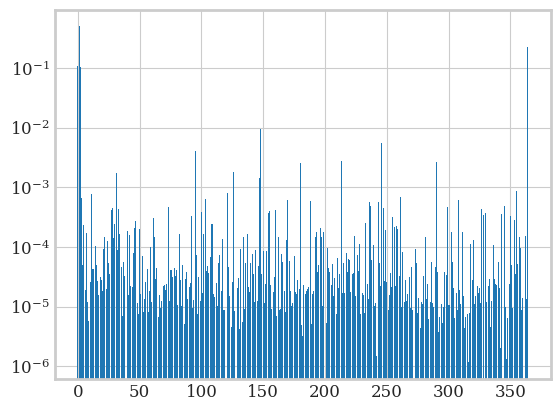

In [14]:
plt.bar(range(365), reg.feature_importances_,)
plt.yscale('log')